In [1]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from DataLoader import Dataset
from Model import LSTM
%matplotlib inline
from joblib import load
from tools import *
from eval import eval
import os
from datetime import datetime
from train import train

In [2]:
df = pd.read_csv('Data/return/btc-usdt-1hr.csv').iloc[:,:6]
df['Open Time'] = pd.to_datetime(df['Open Time'], unit= 's')
df

,Open Time,Open,High,Low,Close,Volume
0,2021-01-01 00:00:00,28923.63,29031.34,28690.17,28995.13,2311.811445
1,2021-01-01 01:00:00,28995.13,29470.00,28960.35,29409.99,5403.068471
2,2021-01-01 02:00:00,29410.00,29465.26,29120.03,29194.65,2384.231560
3,2021-01-01 03:00:00,29195.25,29367.00,29150.02,29278.40,1461.345077
4,2021-01-01 04:00:00,29278.41,29395.00,29029.40,29220.31,2038.046803
...,...,...,...,...,...,...
5817,2021-08-31 20:00:00,47300.00,47322.71,46914.26,46992.60,1375.538340
5818,2021-08-31 21:00:00,46992.60,47200.00,46833.00,46911.50,1488.115700
5819,2021-08-31 22:00:00,46911.49,47104.96,46744.57,47088.84,1359.884290
5820,2021-08-31 23:00:00,47091.36,47345.00,46993.00,47100.89,1242.528870


No handles with labels found to put in legend.


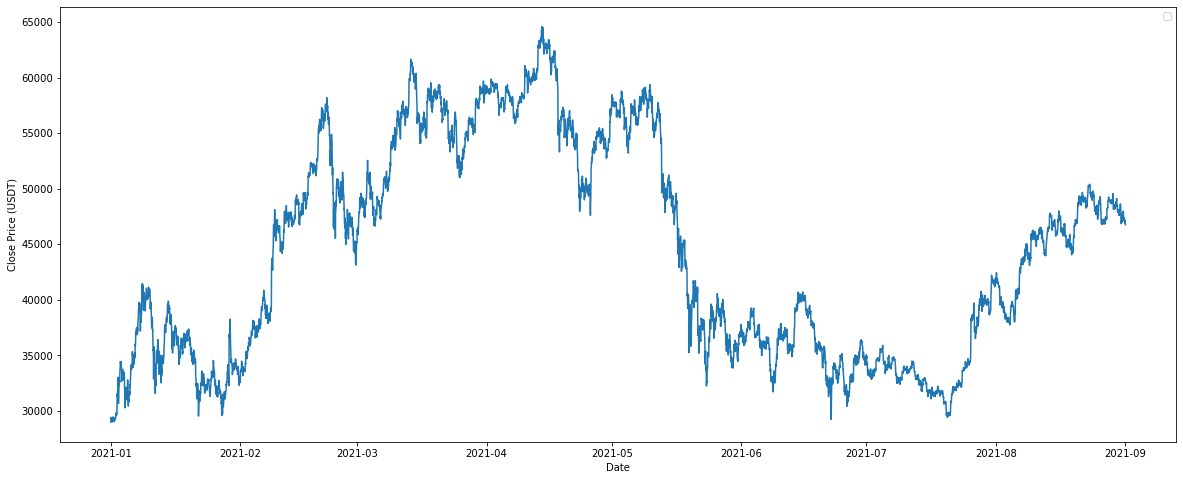

In [3]:
plt.figure(figsize=(20,8))
plt.plot(df['Open Time'], df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price (USDT)')
plt.legend()

In [11]:
#Parameters
epochs = 100
d_model = 2 #num of features
hidden_size = 50
num_layer = 2 #num of LSTM layers
dropout = 0.1
output_size = 1 #predicting 1 data point at a time
timestep = 48 # number of input samples prior to the prediction
batch_size = 1
lr = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scaler = load('scalers/train-scaler-price.joblib')

In [6]:
%%time
#Dataloader
train_dataset = Dataset('Data/return/train-btc-dataset.csv', len_input= timestep)
train_loader = DataLoader(train_dataset, batch_size= 1)

val_dataset = Dataset('Data/return/valid-btc-dataset.csv', len_input= timestep)
val_loader = DataLoader(train_dataset, batch_size= 1)

#Create model object
model = LSTM(d_model= d_model,
            hidden_size= hidden_size,
            num_layer= num_layer,
            dropout= dropout,
            output_size= output_size,
            batch_first= True)

model.double().to(device)

#define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr= lr)

#define loss_fn
criterion = nn.MSELoss()

train_loss_hist = []
val_loss_hist = []
min_val_loss = float('inf')

#training loop
for epoch in range(epochs):
    #initialize hidden and cell state of lstm to zeros tensor
    state_in = (torch.zeros(num_layer, batch_size, hidden_size).double(),
                torch.zeros(num_layer, batch_size, hidden_size).double())
    
    train_loss, val_loss = train(train_loader= train_loader,
                                 val_loader= train_loader,
                                 state_in= state_in,
                                 len_input= timestep,
                                 d_model= d_model,
                                 len_output= output_size,
                                 model= model,
                                 optim= optimizer,
                                 criterion= criterion,
                                 epoch= epoch,
                                 device= device)
    
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        best_state = {
            'epoch': epoch + 1,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'training loss': train_loss,
            'validation loss': val_loss
        }
        
    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    
    print('Epoch: [{}/{}] \t Trainig Loss: {:.3f}e-3 \t Validation Loss: {:.3f}e-3'.format(epoch+1, epochs, train_loss*1000, val_loss*1000))
    
    timestamp = int(datetime.now().timestamp())
    if early_stop(val_loss_hist, patience= 10):
        maybe_make_dir('checkpoints')
        maybe_make_dir('checkpoints/close-price')
        torch.save(best_state, f'checkpoints/close-price/{timestamp}-{timestep}HR-{lr}LR-{dropout}DR-Price.tar')
        break
    elif epoch+1 == epochs:
        maybe_make_dir('checkpoints')
        maybe_make_dir('checkpoints/close-price')
        torch.save(best_state, f'checkpoints/close-price/{timestamp}-{timestep}HR-{lr}LR-{dropout}DR-Price.tar')

Epoch: [1/100] 	 Trainig Loss: 1.921e-3 	 Validation Loss: 142.817e-3
Epoch: [2/100] 	 Trainig Loss: 1.787e-3 	 Validation Loss: 143.607e-3
Epoch: [3/100] 	 Trainig Loss: 1.768e-3 	 Validation Loss: 144.179e-3
Epoch: [4/100] 	 Trainig Loss: 1.672e-3 	 Validation Loss: 143.300e-3
Epoch: [5/100] 	 Trainig Loss: 1.534e-3 	 Validation Loss: 142.307e-3
Epoch: [6/100] 	 Trainig Loss: 1.386e-3 	 Validation Loss: 143.645e-3
Epoch: [7/100] 	 Trainig Loss: 1.287e-3 	 Validation Loss: 144.174e-3
Epoch: [8/100] 	 Trainig Loss: 1.205e-3 	 Validation Loss: 144.258e-3
Epoch: [9/100] 	 Trainig Loss: 1.146e-3 	 Validation Loss: 143.561e-3
Epoch: [10/100] 	 Trainig Loss: 1.054e-3 	 Validation Loss: 144.495e-3
Epoch: [11/100] 	 Trainig Loss: 1.015e-3 	 Validation Loss: 143.371e-3
Epoch: [12/100] 	 Trainig Loss: 0.944e-3 	 Validation Loss: 143.220e-3
Epoch: [13/100] 	 Trainig Loss: 0.872e-3 	 Validation Loss: 141.993e-3
Epoch: [14/100] 	 Trainig Loss: 0.787e-3 	 Validation Loss: 141.877e-3
Epoch: [15/100]

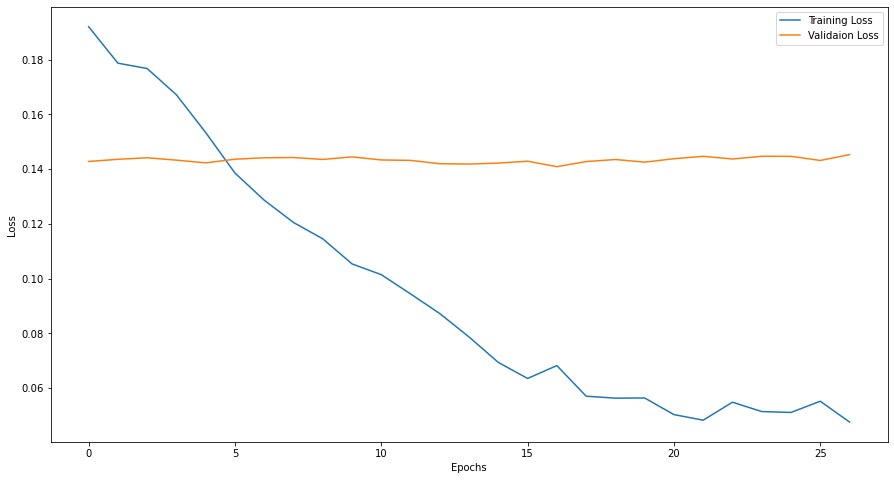

In [8]:
plt.figure(figsize=(15,8))
plt.plot(np.array(train_loss_hist)*100, label= 'Training Loss')
plt.plot(np.array(val_loss_hist), label= 'Validaion Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Prediction ended


Text(0.5, 1.0, 'Train Result')

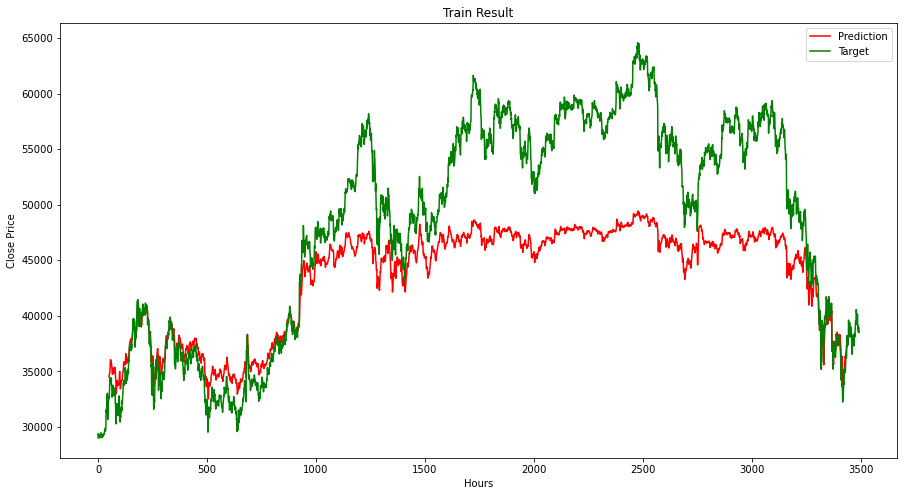

In [13]:
model = LSTM(d_model= d_model,
            hidden_size= hidden_size,
            num_layer= num_layer,
            dropout= dropout,
            output_size= output_size,
            batch_first= True)

checkpoint = os.listdir('checkpoints/close-price')[0]
best_state = torch.load(f'checkpoints/close-price/{checkpoint}')
model.load_state_dict(best_state['model'])
model.double().to(device)

#define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr= lr)

#define loss_fn
criterion = nn.MSELoss()

train_dataset = Dataset('Data/return/train-btc-dataset.csv', len_input= timestep)
train_loader = DataLoader(train_dataset, batch_size= 1)

state_in = (torch.zeros(num_layer, batch_size, hidden_size).double(),
            torch.zeros(num_layer, batch_size, hidden_size).double())

train_pred_hist, train_loss_hist = eval(data_loader= train_loader,
                                        state_in= state_in,
                                        len_input= timestep,
                                        d_model= d_model,
                                        len_output= output_size,
                                        model= model,
                                        scaler= scaler,
                                        criterion= criterion,
                                        device= device)

for i in range(len(train_pred_hist)):
    train_pred_hist[i] = (train_pred_hist[i] * scaler.data_range_[0]) + scaler.data_min_[0]

train_df = pd.read_csv('Data/return/train-btc-raw.csv')
train_pred_close = {'Pred Close' : train_pred_hist}
train_pred_df = pd.DataFrame(train_pred_close)
train_df['Pred Close'] = train_pred_df.shift(timestep + output_size)

plt.figure(figsize=(15,8))
plt.xlabel('Hours')
plt.ylabel('Close Price')
plt.plot(train_df['Pred Close'], label= 'Prediction', color= 'r')
plt.plot(train_df['Close'], label= 'Target', color= 'g')
plt.legend()
plt.title('Train Result')

Prediction ended


Text(0.5, 1.0, 'Train Result')

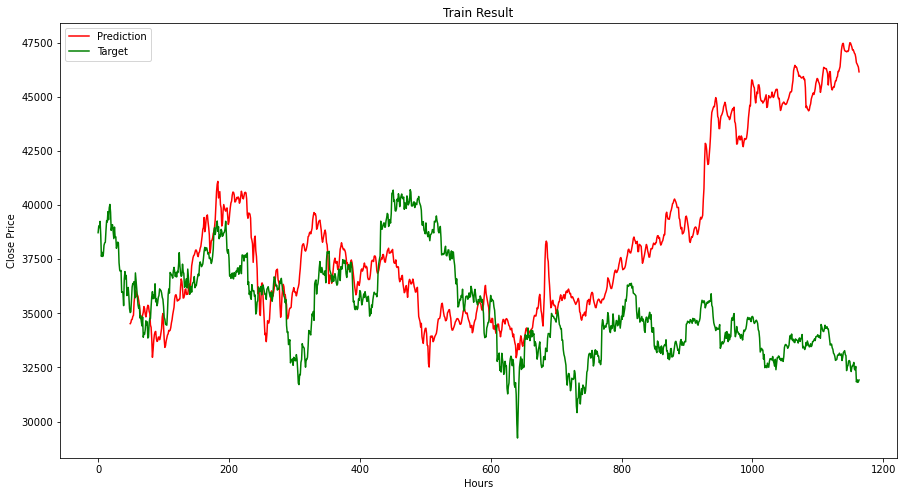

In [14]:
model = LSTM(d_model= d_model,
            hidden_size= hidden_size,
            num_layer= num_layer,
            dropout= dropout,
            output_size= output_size,
            batch_first= True)

checkpoint = os.listdir('checkpoints/close-price')[0]
best_state = torch.load(f'checkpoints/close-price/{checkpoint}')
model.load_state_dict(best_state['model'])
model.double().to(device)

#define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr= lr)

#define loss_fn
criterion = nn.MSELoss()

val_dataset = Dataset('Data/return/valid-btc-dataset.csv', len_input= timestep)
val_loader = DataLoader(train_dataset, batch_size= 1)

state_in = (torch.zeros(num_layer, batch_size, hidden_size).double(),
            torch.zeros(num_layer, batch_size, hidden_size).double())

val_pred_hist, val_loss_hist = eval(data_loader= val_loader,
                                        state_in= state_in,
                                        len_input= timestep,
                                        d_model= d_model,
                                        len_output= output_size,
                                        model= model,
                                        scaler= scaler,
                                        criterion= criterion,
                                        device= device)

for i in range(len(val_pred_hist)):
    val_pred_hist[i] = (val_pred_hist[i] * scaler.data_range_[0]) + scaler.data_min_[0]

val_df = pd.read_csv('Data/return/valid-btc-raw.csv')
val_pred_close = {'Pred Close' : val_pred_hist}
val_pred_df = pd.DataFrame(val_pred_close)
val_df['Pred Close'] = val_pred_df.shift(timestep + output_size)

plt.figure(figsize=(15,8))
plt.xlabel('Hours')
plt.ylabel('Close Price')
plt.plot(val_df['Pred Close'], label= 'Prediction', color= 'r')
plt.plot(val_df['Close'], label= 'Target', color= 'g')
plt.legend()
plt.title('Train Result')

Text(0.5, 1.0, 'Result')

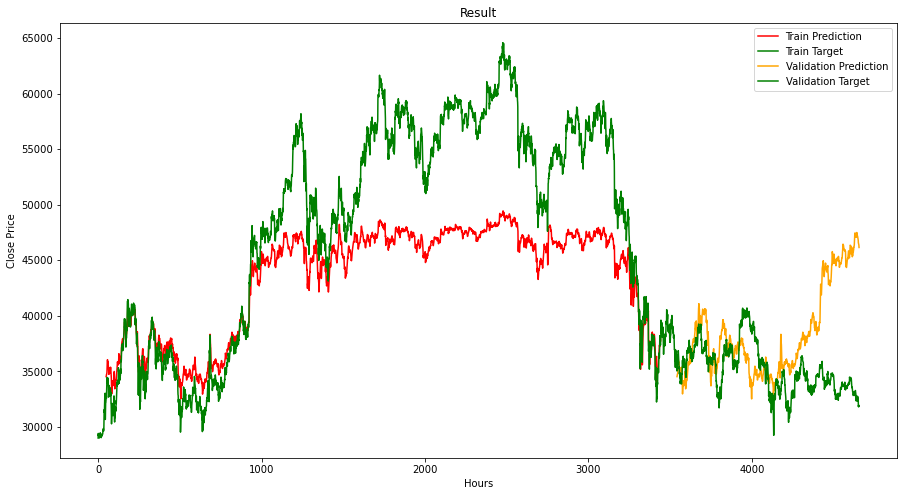

In [15]:
plt.figure(figsize=(15,8))
plt.xlabel('Hours')
plt.ylabel('Close Price')
plt.plot(train_df['Pred Close'], label= 'Train Prediction', color= 'r')
plt.plot(train_df['Close'], label= 'Train Target', color= 'g')
plt.plot([None]*len(train_df) + list(val_df['Pred Close']), label= 'Validation Prediction', color= 'orange')
plt.plot([None]*len(train_df) + list(val_df['Close']), label= 'Validation Target', color= 'g')
plt.legend()
plt.title('Result')